In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import ndimage
from scipy.ndimage import zoom
import gc
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.backends.cudnn as cudnn
from models.sfcn import *
from models.resnet import *
from models.inception_resnet_v2 import *
from models.densenet import *
from models.custom_net import *
from models.shallow_net2 import *
import types
from scipy.stats import pearsonr, spearmanr
import torchio as tio
from datetime import datetime
import wandb
from models.ranking_loss import *

In [3]:
RANDOM_SEED = 551

In [4]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [5]:
def load_data(img_dir, label_dir, label_name, std=False, norm=True):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for i, index in enumerate(filenames):
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        if norm:
            img = (img - img.min()) / (img.max() - img.min())
        if std:
            m = np.mean(img)
            s = np.std(img)
            img = (img - m) / s
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [6]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=12,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(20,20,20))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

In [7]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.X = X
        self.y = y.values
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = np.array([self.y[idx]]).astype('float16')
        if self.transform is not None:
            image = self.transform(image)
        return [image, label]

In [8]:
def train(model, train_loader, lr, weight_decay, optimizer, sorter='sodeep/weights/best_model_gruc.pth.tar'):
    criterion = rank_difference_loss(sorter)
#     criterion = nn.HuberLoss()
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
        
    total_loss, total_mae_loss, total_mse_loss = 0, 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.train()
    for inputs, labels in tqdm(train_loader):              
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        optimizer.zero_grad()

        output = model(inputs)
        
        pred = output.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
        loss = criterion(output, labels)
        mae_loss = criterion1(output, labels)
        mse_loss = criterion2(output, labels)
        loss.backward()
#         mae_loss.backward()
#         mse_loss.backward()
        
        optimizer.step()
        
        total_loss += loss.data.item()
        total_mae_loss += mae_loss.data.item()
        total_mse_loss += mse_loss.data.item()
        
        gc.collect()
        torch.cuda.empty_cache()
        
    return preds, truths, total_loss, total_mae_loss, total_mse_loss
#     return preds, truths, total_mae_loss, total_mse_loss

In [9]:
def valid(model, valid_loader, sorter='sodeep/weights/best_model_gruc.pth.tar'):
    criterion = rank_difference_loss(sorter)
#     criterion = nn.HuberLoss()
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
    
    total_loss, total_mae_loss, total_mse_loss = 0, 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            output = model(inputs)
            
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            loss = criterion(output, labels)
            mae_loss = criterion1(output, labels)
            mse_loss = criterion2(output, labels)
            
            total_loss += loss.data.item()
            total_mae_loss += mae_loss.data.item()
            total_mse_loss += mse_loss.data.item()
        
    return preds, truths, total_loss, total_mae_loss, total_mse_loss
#     return preds, truths, total_mae_loss, total_mse_loss

In [10]:
label_name = 'FL_WMH_VOL_icv'
# label_name = 'FL_WMH_VOL_mL'
# label_name = 'WMH_GRADE'
# label_name = 'Cortical Gray Matter Total Percent Of Icv'
# label_name = 'FL_PVWMH_VOL_icv'
# label_name = 'FL_DWMH_VOL_icv'
img_dir = 'img_npy/'
label_dir = 'labels/data_975.csv'

In [11]:
weight_decay = 0.1
lr_list = [0.01,0.005,0.001,0.0005,0.0001,5e-5,1e-5,5e-6,1e-6]  # MSE loss + weight decay, lr = 10^-2 ~ 10^-6
lr_list = sorted(lr_list)
epochs = 150
batch_size = 16
test_batch_size = 32
optim_class = optim.AdamW
dropout_rate = 0.5
k = 5

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [13]:
# load data
X, y = load_data(img_dir, label_dir, label_name, std=True, norm=True)

# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# train set
train_set = NeckDataset(X_train, y_train)

# test set & loader
test_set = NeckDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=16)

len(X_train), len(X_test), len(y_train), len(y_test)

(780, 195, 780, 195)

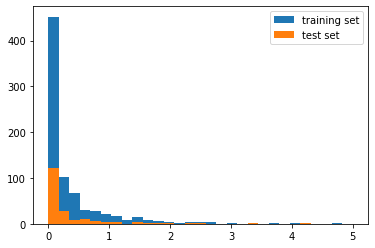

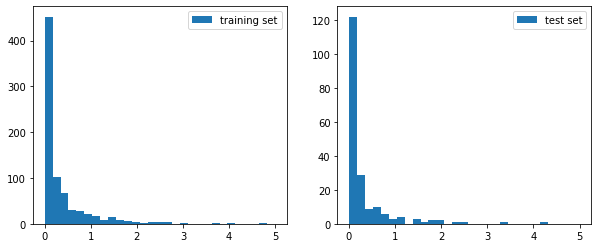

In [14]:
bins = np.linspace(0, 5, 30)

plt.hist(y_train, bins, label='training set')
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')
plt.show()
plt.close()


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y_train, bins, label='training set')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')

plt.show()
plt.close()

In [ ]:
for lr in lr_list:
    print('[ learning rate =', lr, ']')
    
    # 5-Fold cross validation
    set_seed()
    splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

    min_rec, max_p, max_s = 100, 0, 0
    for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
        print('Fold {}'.format(fold + 1))

        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        set_seed()
        model = SFCN(dropout_p=dropout_rate)
        model.fc.add_module('relu', nn.LeakyReLU())
        model = torch.nn.DataParallel(model, device_ids=[0, 1])
        model.cuda()

        wandb.init(project='20230201-learningrate',
                   config={"model": "sfcn+lkrelu", "dropout": dropout_rate,
                           "lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                           "cost_function": "ranking_loss", "optimizer": optim_class.__name__,
                           "fold": fold+1})
        wandb.watch(model)
        
        optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

        best_r, best_mae, best_mse, best_p, best_s = 100, 100, 100, 0, 0

        set_seed()
        for epoch in range(epochs):
            print('# Epoch %d / %d'%(epoch + 1, epochs))   

            # train set
            augment = get_augmentation_transform()
            train_set.transform = augment
            train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

            # validation set
            train_set.transform = None
            valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)

            preds_t, truths_t, rloss_t, mae_t, mse_t = train(model, train_loader, lr, weight_decay, optimizer)
            preds_v, truths_v, rloss_v, mae_v, mse_v = valid(model, valid_loader)

            train_p, _ = pearsonr(preds_t, truths_t)
            train_s, _ = spearmanr(preds_t, truths_t)
            train_mae = mae_t / len(train_loader)
            train_mse = mse_t / len(train_loader)
            train_rloss = rloss_t / len(train_loader)

            valid_p, _ = pearsonr(preds_v, truths_v)
            valid_s, _ = spearmanr(preds_v, truths_v)
            valid_mae = mae_v / len(valid_loader)
            valid_mse = mse_v / len(valid_loader)
            valid_rloss = rloss_v / len(valid_loader)

            if best_r > valid_rloss:
                best_r = valid_rloss
                torch.save(model.state_dict(), 'pretrained/230302_sfcnlkrelu+rankingloss_lr{}_bestr'.format(lr))
            if best_mse > valid_mse:
                best_mse = valid_mse
                torch.save(model.state_dict(), 'pretrained/230302_sfcnlkrelu+rankingloss_lr{}_bestmse'.format(lr))
            if best_mae > valid_mae:
                best_mae = valid_mae
                torch.save(model.state_dict(), 'pretrained/230302_sfcnlkrelu+rankingloss_lr{}_bestmae'.format(lr))
            if best_p < valid_p:
                best_p = valid_p
            if best_s < valid_s:
                best_s = valid_s

            wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                       "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
                       "train_rloss": train_rloss, "valid_rloss": valid_rloss})
        wandb.finish()
        torch.save(model.state_dict(), 'pretrained/230302_sfcnlkrelu+rankingloss_lr{}_fold{}'.format(lr, fold+1))
    

[ learning rate = 1e-06 ]
Fold 1


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.68it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


train_mae,████████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▄▃▃▃▃▂▂▂▂▂▁▁
train_mse,████████▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁
train_pearson,▁▁▁▂▂▂▃▂▃▂▃▄▄▄▄▅▆▆▅▆▆▆▆▆▆▇▆▇▇█▇▇▇███████
train_rloss,▆▅▇▅▆▇▇▆▇▇▄▅▅█▄▆▄▄▅▄▄▄▄▃▄▃▅▃▄▄▄▃▃▂▃▁▂▂▂▁
train_spearman,▁▂▃▃▄▄▅▅▆▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████
valid_mae,▇▇█▇█▇█▇▇▇▅▅▃▃▃▃▄▃▃▂▄▂▂▂▂▃▃▂▂▂▂▂▃▂▂▂▂▃▂▁
valid_mse,▇██▇███▇▇▇▆▆▅▄▄▅▅▄▄▃▃▂▂▂▂▃▃▂▂▁▂▂▂▂▁▂▂▂▁▁
valid_pearson,▁▅███▃▁▂▃▄▅▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█
valid_rloss,▆▅▆▇▅▄▆▁▇▇▂▆▄▆▃▇▄▆▃▅▅▄▅▃▆▅▃▄▅▅▃▄▄█▇▅▃▅▇▃
valid_spearman,▁▃▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██
train_mae,0.27002


Fold 2


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


train_mae,██████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▄▄▃▃▃▃▂▂▂▁▁
train_mse,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▃▂▂▁▁▁
train_pearson,▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▆▆▆▇▆▆▇▇▇▇▇▇▇▇██▇█████
train_rloss,▇▆▇███▆▆▆▅▆▅▆▄▄▆▃▇▃▃▅▂▃▄▄▄▂▂▂▃▂▃▃▁▂▁▂▁▁▁
train_spearman,▁▁▃▃▄▄▄▄▅▆▆▅▆▅▆▅▆▅▇▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇███
valid_mae,▇▇█▇▇█▇▇▇▆▇▆▆▅▅▆▆▅▅▅▂▃▃▄▄▄▂▂▃▃▃▂▂▂▂▂▁▂▁▁
valid_mse,▇▇█▇▇█▇█▇▇▇▆▆▆▅▆▆▅▅▅▂▃▃▄▄▄▂▂▃▃▃▂▂▂▂▁▁▂▂▁
valid_pearson,▃▅▆▆▅▂▁▁▂▂▂▃▃▄▄▄▅▆▆▆▇▇▇▇▇▇█▇████████████
valid_rloss,▅▅█▆▇▅▃▄▆▆▃▄▁▅▄▂▄▄▁▅▁▄▆▂▄▃▃▄▄▇▆▄▃▃▁▃▁▆▄▃
valid_spearman,▁▅▇▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
train_mae,0.25731


Fold 3


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.68it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.68it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


train_mae,███████▇▇▇▇▇▆▆▅▆▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▂▂▁▂▂▁▁
train_mse,███████▇▇▇▇▇▆▆▅▅▅▅▅▄▅▄▃▄▄▄▃▃▃▂▃▃▃▂▂▁▂▁▁▁
train_pearson,▁▁▁▂▂▂▃▃▄▄▅▄▅▆▆▅▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇███▇███
train_rloss,▇▅▆▆▇▇██▆▅▅▅▄▆▅▄▅▄▄▃▄▃▄▃▃▂▃▃▃▂▂▂▂▃▂▂▂▂▁▁
train_spearman,▁▁▂▄▄▅▅▄▅▆▅▆▆▆▆▆▆▇▆▆▆▆▇▆▇▇▇▇▆▇▇▇▇▇█████▇
valid_mae,█▇▇███▇▇▆▅▆▅▆▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▂▃▂▃▃▂▂▂▃▂▂▁
valid_mse,▇▇▇▇▇█▇▇▇▆▆▆▆▆▆▆▅▅▄▅▄▄▅▄▄▄▂▄▃▃▂▃▃▂▂▂▃▂▂▁
valid_pearson,▂▄▆▆▆▂▁▁▂▂▂▂▂▃▃▄▄▄▅▅▅▅▆▅▅▆▇▆▆▇▇▆▇▇▇▇▇▇██
valid_rloss,▄▅▄▃▆▃▂▃▅▄▂▂▅▅▄▇▄▅▃▄▃▄▃▂█▅▂▄▄▅▆▁▂▂▄▂▄▄▁▅
valid_spearman,▁▃▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_mae,0.28267


Fold 4


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.68it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


train_mae,██████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▁▂▂▁▂
train_mse,███████▇▇▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▂▃▃▃▃▃▂▁▂▂▁▁
train_pearson,▁▁▁▁▂▃▂▃▃▃▃▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇██
train_rloss,▆▄▆██▆▇▆▆▇▆▅▄▅▅▄▅▄▃▆▃▆▅▅▄▃▄▃▃▂▃▃▃▃▁▃▁▂▁▂
train_spearman,▁▃▄▃▄▄▅▄▄▅▄▅▅▆▅▆▆▆▆▇▆▆▇▆▆▆▇▇▇▇▇▇▇███▇███
valid_mae,▇▇▇▇█▇▇█▇█▇▇▆▆▅▅▅▅▅▅▅▅▃▃▄▃▃▃▂▂▃▃▂▂▂▃▂▁▂▂
valid_mse,▇▇▇▇█▇▇█▇█▇▇▆▆▆▆▅▅▅▅▆▅▃▄▄▄▃▄▂▃▃▄▃▂▂▃▃▁▂▃
valid_pearson,▄▆▆▂▁▁▁▂▂▂▂▂▂▃▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████████
valid_rloss,▄▇▄█▅█▇▅▆▆▅▆▆▂▃▄▅▁▄▃▂▄▅▃▂▆▃▅▃▄▃▂▅▄▄▄▄▄▆▄
valid_spearman,▁▄▆▆▆▆▆▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train_mae,0.26157


Fold 5


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


train_mae,█████████▇▇▆▇▆▆▅▅▅▅▄▄▄▅▄▃▄▃▃▃▃▃▃▂▃▃▂▂▂▁▁
train_mse,█████████▇▇▇▇▆▆▅▅▅▅▅▅▄▅▄▃▄▃▃▃▃▃▂▂▃▂▁▂▁▁▁
train_pearson,▁▁▁▂▃▂▂▂▃▃▃▄▄▄▅▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█████
train_rloss,▇▇▅▇▇█▇▆█▅▆▅██▄▆▄▄▅▃▄▅▃▅▅▅▁▄▃▄▂▂▃▃▁▁▁▁▂▁
train_spearman,▁▁▂▄▄▄▅▄▅▆▆▆▅▆▇▆▆▆▇▆▇▇▆▆▇▇▇█▇▇▇▇▇▇▇█████
valid_mae,█████████▇▇▆▆▆▅▅▆▅▅▄▄▃▃▃▄▃▂▃▃▄▂▂▃▂▁▁▂▁▂▂
valid_mse,█████████▇▇▇▇▆▆▆▇▆▆▅▅▅▄▄▅▄▃▄▄▄▃▂▃▃▁▂▂▁▃▂
valid_pearson,▄▆▇▇▇▇▆▆▁▂▂▂▂▂▃▃▃▄▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇██▇█
valid_rloss,▅▄▂▆▃▃▆█▅▂▄▆▆▂▄▆▄▃▄▃▂▃▅▃▄▄▄▂▆▃▂▁▃▄▂▂▂▃▄▃
valid_spearman,▁▃▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
train_mae,0.28286


[ learning rate = 5e-06 ]
Fold 1


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


train_mae,███▇▇▆▆▆▅▅▄▄▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▁▁▁
train_mse,██▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇█▇████▇████████████████
train_rloss,█▇█▆▇▆▆▅▅▅▃▃▃▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
train_spearman,▁▃▃▄▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██▇███▇███▇████████
valid_mae,▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▄▁▁▁▁▁▂█▁▁▁▁▃▁▁▁▃▁▂▁▁▁▂▁
valid_mse,▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▃▁▁▁▁▁▂█▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁
valid_pearson,▆▁▁▃▃▅▄▅▅▄▆▆▆▇▇▇▇▇▇▇█▆██▇▇▇▇▇▇▇▇▇█▇█▆▆█▇
valid_rloss,▅▄▅▇▃▃▆▁▅▆▁▅▃▅▃▆▅▅▂▅▅▃▅▆▆▄▂▃▅▄▃▃▄▆▆▄▃▄█▂
valid_spearman,▂▂▁▁▂▄▃▅▆▅▆▆▆▆▇▇▇██▇▇▇█▇▆▇▇▆▇▆▆▇▇▇▆█▇█▇▇
train_mae,0.15665


Fold 2


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


train_mae,████▇▇▆▆▅▅▅▅▄▄▃▃▃▂▂▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,███▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▂▃▃▄▄▅▆▆▇▆▇▇▇▇▇▇█▇████▇████████████████
train_rloss,█▇██▇▇▆▅▅▄▄▄▄▃▃▂▂▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_spearman,▁▂▃▂▃▃▃▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇██████▇██▇███
valid_mae,▃▂▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▂▂▂▁▂▁▂▂▂▂▁█▁▁▂▁▁▁▄▁
valid_mse,▆▅▆▅▅▃▄▄▃▄▅▄▂▃▁▂▁▄▃▁▅▃▁▁▂▁▃▁▄▄▂█▁▃▃▁▂▂▃▃
valid_pearson,▁▂▂▄▄▇████▇██████▆▇▇▅▇▇▇▇▇█▇▆▇▇▇█▇███▇▇▇
valid_rloss,▅▅█▆▆▃▃▃▅▅▃▃▁▄▃▁▃▄▁▃▂▃▅▂▄▃▃▄▅▇▆▄▃▄▂▂▁▅▄▃
valid_spearman,▁▁▂▂▂▃▃▄▅▆▆▆▇▆▇▆▇▆▆▇▇▇█▇██▇▇█▇██▇▇▇███▇█
train_mae,0.14637


Fold 3


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


train_mae,███▇▇▆▆▆▅▅▅▅▄▃▃▃▃▂▃▂▂▂▁▁▂▁▁▂▂▁▂▂▁▁▁▁▁▂▁▂
train_mse,███▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▁▂▃▄▅▆▆▆▆▇▆▇▇▇▇█▇▇█████████████████████
train_rloss,█▇▇▆▆▆▆▆▄▄▄▃▃▃▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_spearman,▁▂▃▄▄▄▄▄▅▅▆▆▆▆▆▇▇▇▇█▇▇██████▇██▇█▇█████▇
valid_mae,▃▃▃▃▃▂▂▂▁▁▂▁▁▂▃▁▂▂▁█▁▂▃▁▂▂▃▁▇▄▂▁▁▅▂▃▅▃▁▁
valid_mse,███▇▇▇▆▆▃▃▅▃▃▇▇▄▁▄▃█▂▁▂▁▁▅▂▂▅▂▁▃▃▄▅▇▃█▂▂
valid_pearson,▄▂▁▂▂▄▅▆▇▇▆▇▇▄▄▇█▇▇█▇████▇▇▇███▇▇█▇▄█▃█▇
valid_rloss,▆▇▅▄█▄▃▄▅▅▂▂▄▅▄▇▂▅▃▄▃▄▂▂▆▆▂▄▄▄▅▁▃▁▄▃▄▆▁▆
valid_spearman,▂▁▂▂▄▃▆▆▆▆▇▇▇▇██▆▇▇▆▇▆▆▇▆▇▇▇▆▇▇█▇▆█▇▆▇▆▆
train_mae,0.16549


Fold 4


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


train_mae,███▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▂▁▂▁▁▂
train_mse,███▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
train_pearson,▁▁▂▃▄▅▅▆▆▇▇▇▇▇▇▇███████████████▇████████
train_rloss,▇▆▇█▇▅▆▅▄▄▄▃▃▃▃▂▂▂▁▂▂▂▂▂▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
train_spearman,▁▂▄▃▄▄▅▄▅▆▅▅▆▇▆▆▇▇▇█▇▇▇▇▇▇▇▇█▇█▇██▇█▇███
valid_mae,▄▄▃▃▃▂▂▂▃▁▃▂▂▁▁▆▂▂▁▁▁▄▁▄▁▂▁▂▁▅▁█▁▁▁▁▂▃▄▃
valid_mse,██▇▇▇▆▅▅▆▂▆▅▅▃▃▂▅▄▁▁▁█▄▁▁▆▄▆▁▂▂▄▁▃▃▂▅▇█▇
valid_pearson,▅▁▂▃▅▆▇█▇█▇██████████▆███▇█▇████████▇█▇█
valid_rloss,▅▇▄█▅▇▆▄▅▄▅▅▅▂▃▄▅▁▃▃▂▅▄▃▃▆▃▅▂▃▃▃▅▄▄▄▄▅▇▅
valid_spearman,▁▂▃▃▄▄▅▆▆▆▆▆▇▇▇▅▇▇▇▆▆█▇▅▆▇▇█▇▇▇▆▇█▇▇▇███
train_mae,0.15328


Fold 5


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


train_mae,███▇▇▆▆▆▅▅▅▄▄▃▃▃▂▃▂▂▁▁▂▂▂▁▁▁▂▂▁▁▁▂▂▁▂▁▁▁
train_mse,███▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
train_pearson,▁▂▃▃▅▅▅▆▆▇▇▇▇▇▇███████▇█████████████████
train_rloss,██▇▇▆▆▅▅▅▄▄▃▄▃▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁
train_spearman,▁▂▃▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█▇▇▇██▇█▇▇██▇███▇██
valid_mae,▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▁▂▂▁▁▇▂▂▂▁▁▂▁▁▂█▃▄▂▂▁
valid_mse,▅▅▅▄▃▄▄▄▄▃▃▄▂▁▁▂▂▃▂▂▃▄▂▁▇▄▄▃▁▂▃▁▁▃█▂▄▃▂▁
valid_pearson,▆▁▂▄▅▅▅▅▅▇▇▆▇▇██▇▇██▇▇██▇▆▇███▇██▇▇▇▇▇██
valid_rloss,▆▅▃▇▄▃▆█▆▃▄▆▅▂▃▄▃▃▄▂▂▄▅▃▅▅▅▃▅▃▃▁▄▅▄▂▄▃▃▂
valid_spearman,▁▁▁▂▂▃▃▄▅▅▅▅▄▆▆▅▅▇▆▇▇▇▄▇▅██▇▇█▇▇▇▇▆▆▅█▆▇
train_mae,0.15854


[ learning rate = 1e-05 ]
Fold 1


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


train_mae,██▇▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▁▂▁▁▁▁
train_mse,██▇▆▅▄▃▃▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▁▄▅▆▆▇▇▇▇██████████████████████████████
train_rloss,███▅▅▅▄▃▃▃▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁
train_spearman,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇█▇▇▇██▇███▇███▇███▇████
valid_mae,▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▃▅▂▁▁▁▂▁█▂▁▁▁▁▁▁▁▄▁▁▁▁▁▂▂
valid_mse,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▂▁▁▁▁▁█▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
valid_pearson,▁▁▂▄▅▆▅▆█▅█▇▇▇▆▇▆▇▅▆▅▆█▇▆▆▇▆▇▆▆▇▆▇▆▇▇▅▇▇
valid_rloss,▄▃▄▆▄▃▅▃▄▅▁▆▃▄▃▇▆▄▂▅▃▄▄▆▆▄▂▃▄▃▂▃▄▅▅▃▂▃█▃
valid_spearman,▁▂▁▁▃▄▅▅▆▅▅▆▇▅▅▇▅▆█▆▇▆▇▅▆▆▇▆▇▆▅▆▆▇▇▇██▆▆
train_mae,0.1523


Fold 2


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


train_mae,██▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train_mse,██▇▇▆▅▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▂▃▄▅▆▆▇▇████▇██████████████████████████
train_rloss,███▇▆▆▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_spearman,▁▂▃▃▄▅▅▅▆▇▆▇▇▇▇▇▇▇▇█▇██▇▇██████████▇▇███
valid_mae,▂▂▂▂▂▂▂▁▂▂▁▂▂▁▆▂▁▁▂▁▂▂▁▅▂▂▂▂▁▂▁█▃▁▂▁▁▁▁▁
valid_mse,▃▃▃▃▂▃▃▂▃▁▁▁▃▂▆▁▁▂▁▂▃▂▂▄▁▁▃▂▂▃▂█▂▁▃▁▂▁▁▂
valid_pearson,▁▂▅▆██▅█▆▇█▇▆▇▇▆▆▆▇▆▄▇▇▆▆▆▃▇▆▅▆▆▆▇▄▇▇▇▇▇
valid_rloss,▅▆█▅▆▄▄▂▆▄▂▂▂▄▃▂▃▃▁▄▃▄▆▃▄▄▄▄▅█▇▅▄▃▂▂▁▅▄▃
valid_spearman,▁▂▂▅▅▅▅▇▇▇█▇▇▇██▇▇▇▇█▇█▅▇▇▆▇▇▇█▆▆▇▇█▇█▇▇
train_mae,0.13542


Fold 3


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


train_mae,██▇▇▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▂▁▂
train_mse,██▇▆▅▄▄▃▃▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▁▃▄▅▆▆▇▇▇▇▇▇██▇████████████████████████
train_rloss,█▇▇▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_spearman,▁▂▄▄▅▅▅▆▅▆▇▇▇▇▇▇▇▇██▇▇██████▇██▇█▇▇████▇
valid_mae,▂▂▂▂▁▂▃▂▃▁█▁▁▂▂▁▄▂▂▄▁▄▄▃▁▂▅▁▁▂▄▂▁▁▂▁▁▂▁▁
valid_mse,▄▄▄▃▂▃▂▃▂▁█▂▂▄▄▂▃▁▁▃▁▂▃▂▂▃▄▁▁▁▂▃▁▂▄▂▁▃▂▁
valid_pearson,▂▁▁▄▇▅▇▆▇▇▇▇▇▃▅█▇██▇▇█▇██▅█▇███▇▇▇▄▆▇▆▇▇
valid_rloss,▇█▅▃▆▄▃▄▅▄▂▁▅▇▄▆▂▅▂▅▃▄▃▂█▇▃▅▄▅▆▁▃▂▅▂▅▆▁▆
valid_spearman,▂▁▃▄▇▇▆█▆▇▇▇▇▇▇▇▇▇█▅▆▆▅▇▆▇▇▆▇▇▆████▇▇▇▇▇
train_mae,0.16294


Fold 4


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


train_mae,██▇▇▆▅▅▄▄▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▂▂▁▂▁▂▂▁▂▁▁▁▁▁
train_mse,██▇▇▆▅▄▄▃▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
train_pearson,▁▂▂▄▅▆▆▆▇▇▇▇██▇▇███████████████▇████████
train_rloss,█▆▇█▆▅▅▄▃▃▂▂▁▁▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
train_spearman,▁▃▃▃▄▅▆▅▆▇▆▆▇▇▇▇▇▇▇█▇█▇▇▇▇▇▇█▇█▇██▇█▇███
valid_mae,▂▂▁▁▂▁▁▁▂▁▂▂▂▁▁█▁▁▃▁▁▁▂▂▁▁▁▂▁▃▃▄▁▃▁▁▁▂▂▂
valid_mse,▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂█▁▂▂▁▁▁▁▁▂▂▂▂▁▂▂▃▂▂▁▂▂▂▂▂
valid_pearson,▁▂▄▆▇███▇█▅▅▅▇▇▇█▇█▇███▇▆▆▆▆████▇█▇▇▇▇▇▅
valid_rloss,▅█▄█▆▇▆▄▆▅▅▇▆▂▃▄▄▁▃▃▂▄▄▄▃▇▄▆▃▃▄▃▆▄▄▅▄▆█▆
valid_spearman,▁▁▂▅▅▅▆▆▅▆▇▆▄▅▅▂▄▅▅▅▅▆▃▂▅▆▆█▆▅▅▃▆▄▅▆▆▇█▇
train_mae,0.1482


Fold 5


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


train_mae,██▇▆▆▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▂▁▁▁▂▂▁▂▁▁▁
train_mse,██▇▆▅▅▄▃▃▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▂▄▅▆▆▆▇▇▇█▇██████████▇█████████████████
train_rloss,██▆▆▅▅▄▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁
train_spearman,▁▂▃▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇███▇▇▇██▇███▇█▇
valid_mae,▂▂▂▂▁▁▂▂▂▁▂▂▁▃█▂▁▁▄▃▂▂▂▂▇▂▂▂▁▂▂▃▂▂█▃▄▂▇▂
valid_mse,▃▃▂▂▁▁▂▂▁▁▂▃▁▂█▁▁▂▃▂▂▂▂▁█▃▃▂▁▃▁▂▂▂█▂▃▂▆▂
valid_pearson,▄▁▄▆▆▇▆▇▇██▆▇▇▇▇██▇▇▇▇▇▇▇▆▆▇█▅▇▇█▇▇▇▇▇▇▇
valid_rloss,▇▅▂▆▄▂▆█▄▁▃█▅▄▄▅▂▂▆▂▁▃▆▃▇▅▅▃▅▅▃▁▃▄▃▁▃▃▄▂
valid_spearman,▂▁▁▃▄▅▄▆▅▇▅▆▅▅▅▄▆▇▅▆▇▇▃▆▁▇█▇▇█▆▇█▇▄▅▅▇▂▇
train_mae,0.15095


[ learning rate = 5e-05 ]
Fold 1


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


train_mae,██▆▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
train_mse,██▅▄▄▃▂▂▂▂▂▁▂▂▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▂▄▅▆▆▇▇████████████████████████████████
train_rloss,█▇▇▅▄▄▂▂▂▂▂▂▁▂▁▂▂▁▂▂▁▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
train_spearman,▁▂▃▄▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇██▇███▇████
valid_mae,▁▁▂▅▅▃▁▁▁▁▇▁▁▁▂▁▄▂▁█▁▁▂▅▁▁▁▂▄▁▁▁▃▄▁▁▁▁▅▁
valid_mse,▁▁▁▄▄▃▁▁▁▁▇▁▁▁▁▁▃▁▁█▂▁▁▅▁▁▂▁▃▁▁▁▂▂▁▁▁▁▄▁
valid_pearson,▂▆▄██▆▆▅▆▆▇▆▆▄▅▅▆█▆▄▅▆▆▆▅▆▅▅▃▅▅▆▃▂▅▆▅▄▁▅
valid_rloss,▄▄▅█▅▅▄▁▄▅▄▆▃▄▄▅▆▅▂▇▃▃▄▇▆▅▂▅▅▄▃▃▄▇▅▃▂▃▇▃
valid_spearman,▄▃▃▆▆▅▄▅▅▆▅▅▆▆▄▇▅▆▇▄▇▇▆▅▆▆▆▅▃▇▅▇▄▂▆▇█▇▁▇
train_mae,0.13913


Fold 2


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


train_mae,██▇▆▅▅▄▃▃▂▂▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,██▇▅▄▃▃▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▁▃▄▅▆▇▇▇▇█▇▇███████████████████████████
train_rloss,███▆▅▅▃▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_spearman,▂▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇███▇███████████▇███
valid_mae,▂▂▂▂▁▂▂▁▂▁▂▂█▁▂▁▂▁▁▁▁▁▁▁▂▂▁▃▂▂▁▂▃▁▁▂▁▁▁▁
valid_mse,▂▂▁▂▁▂▂▁▂▁▂▂█▁▁▂▁▁▂▁▁▁▁▁▂▂▁▂▂▂▁▁▂▁▁▂▁▁▂▂
valid_pearson,▁▄▆▅█▅▃█▄▇▆▅▅▇▇▇▆▇▆▇▆█▆▇▄▅▇▇▄▅▇▇▆██▆▇▇▆▇
valid_rloss,▅▅▅▅▄▅▃▁▆▄▃▄▃▃▂▂▃▂▂▃▁▂▅▂▅▄▂▄▅█▆▄▄▃▁▂▁▅▄▄
valid_spearman,▄▅▆▅▇▁▂█▁▇▅▅▁██▇▆▇▇█▆▇▇▇▇▇▆▅▇▅▇▇▅▇▇▇█▇▇█
train_mae,0.12367


Fold 3


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


train_mae,██▆▆▅▄▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁
train_mse,██▆▅▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▁▄▄▅▆▇▇▇▇▇▇▇██▇█▇██████████████████████
train_rloss,█▇▆▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_spearman,▁▂▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇██▇▇██████▇████▇██████
valid_mae,▁▁▁▁▁▁▄▁▃▄█▅▅▁▁▁▁▂▂▁▁▁▂▁▃▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
valid_mse,▁▁▁▁▁▁▃▁▂▃█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▂▁▄▆█▆▆▆█▇▇▇▇▇█▇▅▇▇▆▇██▆█▇█▇▇█▇▇▇█▇▆▇▇▆▇
valid_rloss,▆█▅▂▅▅▇▇▇▆▆▄▇▄▂▆▄▆▄▄▄▄▃▃▆▆▃▅▅▆▇▁▃▂▃▃▄▅▂▇
valid_spearman,▃▂▆▆▆▇▅▆▅▃▂▁▁█▅▇▇▄▆█▇▅▆▇▃▆▇▅▇▆▇▇▇▅█▇▅▇▇▇
train_mae,0.13848


Fold 4


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.67it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


wandb: Network error (ConnectionError), entering retry loop.


train_mae,█▇▇▆▅▄▄▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁
train_mse,█▇▆▅▄▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
train_pearson,▁▂▃▅▆▇▇▇█▇▇▇██▇███████▇█████████████████
train_rloss,█▆▇▇▅▄▄▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▂▂▁▁▂▁▂▁▂▁▁▁▁▁▁
train_spearman,▁▃▄▄▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇█▇████▇███
valid_mae,▁▁▁▁▁▁▁█▁▁▁▁▄▁▁▄▂▁▂▁▄▁▁▁▂▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁
valid_mse,▁▁▁▁▁▁▁█▁▁▁▁▂▁▁▂▂▁▁▁▂▁▁▁▂▂▁▁▁▇▁▁▁▁▁▁▁▁▁▁
valid_pearson,▃▁▇▇▅▆█▇▇███▇█▇█▇█▇▇▆▅▆▇▇▆▇▇█▇▄▇▆█▇▃▇▇▂▇
valid_rloss,▅█▄▇▆▇█▆▇▅▄▄▅▂▃▆▅▁▄▃▄▅▆▄▆█▄▅▃▅▄▃▆▄▅▆▆▅█▆
valid_spearman,▃▄▆▅▆▅▇▄▇▇▅▅▁▆▆▆▄█▆▆▃▇▅▆▆▇▅▇▇▂█▅▇▇▇▇▇▇▇▆
train_mae,0.13969


Fold 5


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


train_mae,█▇▆▆▅▅▄▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁
train_mse,█▇▆▅▄▄▃▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▃▄▅▅▆▇▇▇▇█▇██▇███████▇█████████████████
train_rloss,██▆▆▆▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▁
train_spearman,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███▇▇▇██▇███▇██
valid_mae,▁▂▁▂▄▁▁▁▁▁▁▁▄▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▁▁
valid_mse,▁▁▁▁▃▁▁▁▁▁▁▁▃▂█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▅▁▄▄▅▅▇▄▄▃▇▅▅▄▅▄█▆▇▆▇▄▇▆▆▇▅▅▅▇▆▆▆▅▆▇▅▇▆▇
valid_rloss,▆▄▂▆▇▄▅█▅▃▂▆██▅▆▂▄▄▄▂▃▅▅▃▅▄▃▆▃▃▁▃▆▇▁▆▂▃▂
valid_spearman,▇▁▇▆▆▆▆▆▇▇▇▇▆▆▅▆▇▇▇▇▇▇▆▇▆▆▇▇█▇█▇▇▆▇▆▆▇▆█
train_mae,0.13605


[ learning rate = 0.0001 ]
Fold 1


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.80it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


train_mae,█▇▇▆▅▅▄▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
train_mse,█▇▅▄▄▄▂▂▂▂▂▁▂▂▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▃▄▅▆▆▇▇▇▇███▇██████████████████████████
train_rloss,█▇▇▅▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
train_spearman,▁▂▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇███▇▇███████
valid_mae,▁▂█▃▃▅▁▁▁▂▃▁▁▄▁▁▃▂▁▂▁▁▁▁▁▁▁▁▂▁▃▁▁▂▁▁▁▁▃▁
valid_mse,▁▂█▂▂▄▁▁▁▁▂▁▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▂▁
valid_pearson,▃▇▅██▅▄▄▅▅▄▅▄▃▁▄▅▆▅▄▆▅▅▆▅▄▅▃▄▅▄▅▃▄▅▄▅▅▅▄
valid_rloss,▃▆▅▅▄▄▄▁▃▆▄▃▂▅▂▃▇▄▂▆▂▂▃▃▃▃▂▃▅▃▆▂▃▆▃▃▂▃█▃
valid_spearman,▄▅▄▆▇▄▅▅▅▅▄▇▅▄▁▇▅▇█▄██▅▇▆▇▇▃▅▇▄█▄▆█▆▇▇▆▆
train_mae,0.14189


Fold 2


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.76it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


train_mae,█▇▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
train_mse,█▇▆▅▄▄▃▃▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▂▄▅▅▆▆▇▇▇▇▇▇████▇██████████████████████
train_rloss,█▇▇▆▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_spearman,▁▃▄▄▅▅▆▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████████
valid_mae,▂▂▂▂▂▁▂▂▂▃▂█▂▂▁▁▂▁▂▃▃▁▁▁▄▂▁▁▁▂▁▁▂▁▁▂▁▁▁▁
valid_mse,▃▂▂▃▁▂▂▁▃▂▃█▁▁▁▂▁▁▂▂▂▁▁▁▂▁▂▂▂▃▁▁▁▂▂▂▁▁▁▁
valid_pearson,▁▅▇▃▅▇▄█▃▇▅▆▇▇▇▇▇▇▅▆▆▇▆█▅▆▆▆▆▄▇▇▇█▆▆▇█▇▇
valid_rloss,▅▅▆▆▆▃▄▂▆▅▃▅▂▃▃▂▃▃▂▄▃▃▆▂▅▅▃▄▅█▆▄▄▄▂▃▁▅▄▃
valid_spearman,▄▅▆▂▃▅▂▇▁▅▆▅▄▇▇▇▆▇▇▅▆▆▆▇▅▅▆▇▇▆██▇▇▇▇█▇▇█
train_mae,0.12025


Fold 3


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


train_mae,█▇▆▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▁▁▁▁▁▂▁▁
train_mse,█▇▆▅▄▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▃▄▄▅▆▆▇▇▇▇▇▇███████████████████████████
train_rloss,█▆▆▅▅▄▄▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_spearman,▁▂▅▅▅▆▅▆▆▇▇▇▇▇▇█▇▇███▇██████▇███████████
valid_mae,▂▁▁▂▁▁█▂▁▁▁▁▂▂▂▇▁▁▂▁▁▁▁▁▄▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁
valid_mse,▂▂▁▁▂▁█▂▁▂▁▁▁▂▂▆▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
valid_pearson,▁▄▅▇▇▆▆▂▇▅▇▇▆▂▄▆▆▇▇█▅▇▇▇▇▆▇▆▇█▇▆▆█▇▆██▇▆
valid_rloss,▆▆▄▁▇▃▇▄▆▅▁▂▆▆▄█▃▄▄▃▃▄▃▂▇▆▂▅▄▄▆▁▃▂▃▂▅▅▁▇
valid_spearman,▂▃▆▅▇▅▄▅▆▅▆▆▅█▇▁▇▇▆███▆█▃▇▇▃▆▆▇▇▇█▇▇▇██▇
train_mae,0.14048


Fold 4


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 21 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 22 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 23 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 24 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 25 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 26 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 27 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 28 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 29 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 30 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 31 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 32 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 33 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 34 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 35 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 36 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 37 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 38 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 39 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 40 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 41 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 42 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 43 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 44 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 45 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 46 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 47 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 48 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.01it/s]


# Epoch 49 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 50 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 51 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 52 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 53 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 54 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 55 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 56 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 57 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 58 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 59 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 60 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 61 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 62 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 63 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 64 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 65 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 66 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 67 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 68 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 69 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 70 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 71 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 72 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 73 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 74 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 75 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 76 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 77 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 78 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 79 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 80 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 81 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 82 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 83 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 84 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 85 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 86 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 87 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 88 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 89 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 90 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 91 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 92 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 93 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 94 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 95 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 96 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 97 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 98 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 99 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 100 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 101 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 102 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 103 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.93it/s]


# Epoch 104 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 105 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 106 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 107 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 108 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 109 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 110 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 111 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 112 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 113 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 114 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 115 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 116 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 117 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 118 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.82it/s]


# Epoch 119 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 120 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 121 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 122 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 123 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 124 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 125 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.78it/s]


# Epoch 126 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 127 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 128 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.86it/s]


# Epoch 129 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 130 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 131 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 132 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 133 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 134 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 135 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.91it/s]


# Epoch 136 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 137 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 138 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 139 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 140 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 141 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 142 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 143 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 144 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.84it/s]


# Epoch 145 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.04it/s]


# Epoch 146 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 147 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 148 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 149 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 150 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


train_mae,█▇▆▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁
train_mse,█▇▆▅▄▃▃▃▂▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_pearson,▁▂▄▅▅▆▆▇▇▇▇▇████████████████████████████
train_rloss,█▆▇▇▆▄▅▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁
train_spearman,▁▃▄▄▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇█▇█▇█▇████████
valid_mae,▁▁▁▁▁▁▁█▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂
valid_mse,▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▁▇▅█▇▇▅▇▇▇▆▇▇▇▆▇█▇▆▇█▆▇▇▇▅▇█▇█▇█▆█▆▆▇▆▄▇
valid_rloss,▅█▄▇▆▇▇▇▅▇▅▅▅▃▄▆▄▁▃▄▃▅▆▅▃▇▄▄▃▄▃▃▆▆▅▄▅▅█▆
valid_spearman,▂▃▇▄▄▃▄▃▃▄▆▁▄▃▄▂▅▇▇▃▆█▃▂▅▆▅▆▅▆▆▆▆▅▇▆▅▆▆▃
train_mae,0.13786


Fold 5


# Epoch 1 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.06it/s]


# Epoch 2 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 3 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.87it/s]


# Epoch 4 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 5 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 6 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 7 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.95it/s]


# Epoch 8 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 9 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.81it/s]


# Epoch 10 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.85it/s]


# Epoch 11 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 12 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 13 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 14 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 15 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 16 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.83it/s]


# Epoch 17 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.94it/s]


# Epoch 18 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.90it/s]


# Epoch 19 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 20 / 150


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 21 / 150


 18%|███████▉                                    | 7/39 [00:05<00:19,  1.64it/s]

In [16]:
import seaborn as sns

def predict(model, data_loader, title='', line=False):
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
    # Get correlation coefficients
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
    
    # For range setting
    _min = y_min
    _max = y_max
    
    # Figure size
#     plt.figure(figsize=(5, 5))
    
    # Reference line
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='gray', ls='--', label='Reference r = 1.0')
    
    # Regression Plot
    
    ## Scatter
    plt.scatter(truths, preds, c='steelblue', label='Pearson\'s r = {:.2f} / Spearman\'s r = {:.2f}'.format(pearson,spearman))
    
    ## Linear Regression Line
    if line:
        m, b = np.polyfit(truths, preds, 1)
        plt.plot(truths, m*truths + b, c='steelblue', label='m = {:.2f}'.format(m))
#     # Regression Plot at once
#     sns.regplot(x=truths, y=preds, ci=None, color='steelblue', label='Pearson r = {:.2f}'.format(pearson))

    if title != '':
        plt.title(title)
    
    plt.axis('square')
    plt.ylabel('Predicted WMH'); plt.xlabel('Ground Truth')
    plt.legend()
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.show()
    plt.close()
    
    return preds, truths

In [18]:
y_min, y_max =y_test.min(), y_test.max()
y_min, y_max

(0.0, 4.201782967868128)

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


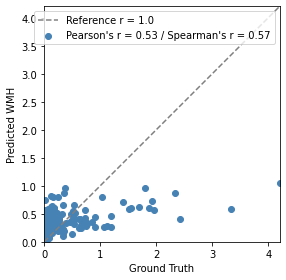

In [19]:
_,_ = predict(model, test_loader)

In [ ]:
net = SFCN()
net.load_state_dict(torch.load('pretrained/230131_sfcn+mae_best'))
net.to(device)
_,_ = predict(net, test_loader)

In [ ]:
dataset = NeckDataset(train_X, train_y)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16)
_,_ = predict(model, train_loader, 'Training set')